In [ ]:
# reference:
# https://gist.github.com/huks0/e48d604fc9dd91731bc687d6e3933db4

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import pytesseract

225.0


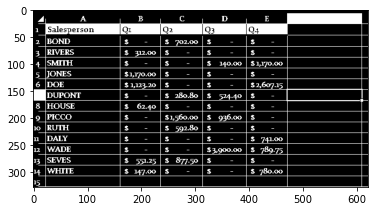

In [74]:
img = cv2.imread('example.png', 0)

thresh, img_bin = cv2.threshold(img, 225, 255, cv2.THRESH_BINARY)
print(thresh)

img_bin = 255 - img_bin
plt.imshow(img_bin, cmap='gray')
plt.show()

In [8]:
# countcol(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1] // 100

# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

print('kernel width:', kernel)

kernel width: [[1 1]
 [1 1]]


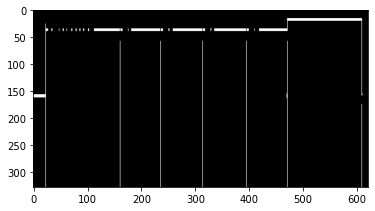

In [9]:
# detect vertical lines
img_ver = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(img_ver, ver_kernel, iterations=3)
plt.imshow(img_ver, cmap='gray')
plt.show()

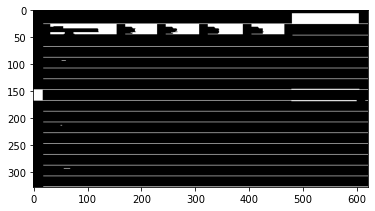

In [11]:
# detect horizon lines
img_hor = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(img_hor, hor_kernel, iterations=3)
plt.imshow(img_hor, cmap='gray')

plt.show()

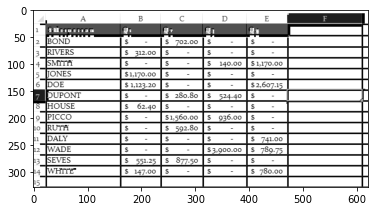

In [13]:
# Combine horizontal and vertical lines in a new third image
# with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
img_vh = cv2.erode(~img_vh, kernel, iterations=2)

thresh, img_vh = cv2.threshold(img_vh, 200, 255, cv2.THRESH_BINARY)
bitxor = cv2.bitwise_xor(img, img_vh)
bitnot = cv2.bitwise_not(bitxor)

plt.imshow(bitnot, cmap='gray')
plt.show()

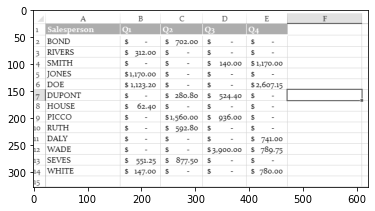

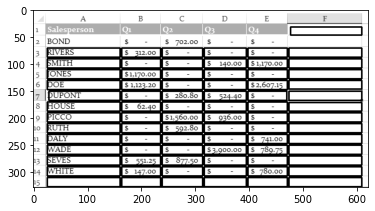

In [103]:
# get the contours and bounding boxes of the excel sheet
_, contours, hierarchy = cv2.findContours(
    img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

boundingBoxes = [cv2.boundingRect(c) for c in contours]
(contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes),
    key=lambda b:b[1][1]))

new_img = np.copy(img)

plt.imshow(new_img, cmap='gray')
plt.show()

boxes = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if w < 10 or h < 10 or w > 500 or h > 30:
        continue
    boxes.append((x,y,w,h))
    image = cv2.rectangle(new_img, (x,y), (x+w,y+h), (0,0,0), 2)
    
plt.imshow(image, cmap='gray')
plt.show()

In [104]:
heights = [box[3] for box in boxes]
mean_height = np.mean(heights)
print(mean_height)

16.949367088607595


In [150]:
rows = []
column = []
j = 0

for i in range(len(boxes)):
    if i == 0:
        column.append(boxes[i])
        previous = boxes[i]
        continue
        
    if boxes[i][1] >= previous[1] + mean_height/2:
        rows.append(column)
        column = []
        
    column.append(boxes[i])

    previous = boxes[i]
    if i == len(boxes) - 1:
        rows.append(column)
        break

n_col = max(len(row) for row in rows)
print([len(row) for row in rows])
print("# of columns:", n_col)

# filter out rows that are too short
rows = list(filter(lambda x: len(x)==n_col, rows))
n_row = len(rows)
print("# of rows:", len(rows))

# sort each row in boxes
for i in range(len(rows)):
    rows[i] = sorted(rows[i], key=lambda x: x[0])

for row in rows:
    print(row)

[1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
# of columns: 6
# of rows: 13
[(26, 70, 135, 17), (164, 70, 72, 17), (239, 70, 75, 17), (317, 70, 78, 17), (398, 70, 73, 17), (474, 70, 135, 17)]
[(26, 90, 135, 17), (164, 90, 72, 17), (239, 90, 75, 17), (317, 90, 78, 17), (398, 90, 73, 17), (474, 90, 135, 17)]
[(26, 110, 135, 17), (164, 110, 72, 17), (239, 110, 75, 17), (317, 110, 78, 17), (398, 110, 73, 17), (474, 110, 135, 17)]
[(26, 130, 135, 17), (164, 130, 72, 17), (239, 130, 75, 17), (317, 130, 78, 17), (398, 130, 73, 17), (474, 130, 135, 16)]
[(29, 150, 132, 17), (164, 150, 72, 17), (239, 150, 75, 17), (317, 150, 78, 17), (398, 150, 72, 17), (474, 150, 135, 17)]
[(26, 170, 135, 17), (164, 170, 72, 17), (239, 170, 75, 17), (317, 170, 78, 17), (398, 170, 73, 17), (474, 171, 135, 16)]
[(26, 190, 135, 17), (164, 190, 72, 17), (239, 190, 75, 17), (317, 190, 78, 17), (398, 190, 73, 17), (474, 190, 135, 17)]
[(26, 210, 135, 17), (164, 210, 72, 17), (239, 210, 75, 17), (317, 210, 78, 17), (398

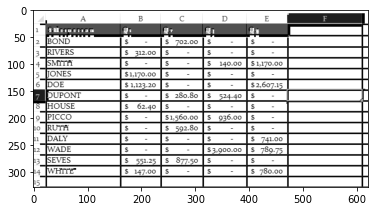

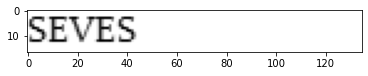

SEVES



In [143]:
import pytesseract
y, x, w, h = rows[10][0]

plt.imshow(bitnot, cmap='gray')
plt.show()

cell = bitnot[x:x+h, y:y+w]
plt.imshow(cell, cmap='gray')
plt.show()

out = pytesseract.image_to_string(cell)

print(out)

In [172]:
from pandas import DataFrame

alldata = []

for row in rows:
    for y, x, w, h in row:
        cell = bitnot[x:x+h, y:y+w]
        out = pytesseract.image_to_string(cell)

        alldata.append(out.strip())

data = DataFrame(np.array(alldata).reshape(n_row, n_col))
print(data)

          0           1          2          3           4 5
0   RIVERS:    $ 312.00                                    
1     SMITA                          $ 140.00   $1,170.00  
2     JONES   $1,170.00                                    
3       DOE  $ 1,123.20                        $2,607.15,  
4    JUPONT               $ 280.80   $ 524.40              
5     HOUSE     $ 62.40                                    
6     PICCO              $1,560.00   $ 936.00              
7      RUTH              $ 5092.80                         
8      DALY                                      $ 741.00  
9      WADE                         $3,900.00   $ 7890.75  
10    SEVES    $ 551.25   $ 877.50                         
11  WHYTTe”    $ 147.00                          $ 780.00  
12                                                         


In [173]:
display(data)

0           1          2          3           4 5
0   RIVERS:    $ 312.00                                    
1     SMITA                          $ 140.00   $1,170.00  
2     JONES   $1,170.00                                    
3       DOE  $ 1,123.20                        $2,607.15,  
4    JUPONT               $ 280.80   $ 524.40              
5     HOUSE     $ 62.40                                    
6     PICCO              $1,560.00   $ 936.00              
7      RUTH              $ 5092.80                         
8      DALY                                      $ 741.00  
9      WADE                         $3,900.00   $ 7890.75  
10    SEVES    $ 551.25   $ 877.50                         
11  WHYTTe”    $ 147.00                          $ 780.00  
12